<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/Tutorial_I_Dflat_Library_and_Neural_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone D$\flat$ and install (also enable GPU runtime)

D$\flat$ is a rather large repository and the dependents (e.g. tensorflow) can also take time to download and install the first time around. These may take a few minutes. 

In [ ]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

%cd /content/DFlat
!python setup.py develop

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'DFlat'...
remote: Enumerating objects: 3188, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 3188 (delta 70), reused 193 (delta 63), pack-reused 2977
Receiving objects: 100% (3188/3188), 1.02 GiB | 13.44 MiB/s, done.
Resolving deltas: 100% (1126/1126), done.
Updating files: 100% (357/357), done.
Filtering content: 100% (19/19), 77.92 MiB | 47.89 MiB/s, done.
/content/DFlat
running develop
running egg_info
creating DFlat.egg-info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
writing manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Crea

In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.7/157.7 KB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gdspy: filename=gdspy-1.6.12-cp38-cp38-linux_x86_64.whl size=597213 sha256=74f67cc91227ecd6c21cd21ada0fc2e887688872a3bac7196dd7d6e6201e17c7
  Stored in directory: /root/.cache/pip/wheels/03/ed/d5/f89483da9ebf5b67e58ba967e19132ae7703a6409727790445
Successfully built gdspy


# Look at the metacell libraries currently saved in D$\flat$


In [ ]:
import dflat.datasets_metasurface_cells as df_library

We can view the names of the saved libraries by calling the list_libraries() function. Note that at the moment, only three libraries are included :(

I am actively improving Dflat and hope to include more libraries in the future as I generate them. I appreciate any researcher who is willing to share their metacell datasets and include them in the D$\flat$ repository. 

In [ ]:
df_library.list_libraries()

['Nanofins_U350nm_H600nm', 'Nanocylinders_U180nm_H600nm', 'Nanoellipse_U350nm_H600nm']


The libraries are loaded below. The loadLibrary call can be used as a helper function that takes in the library string and loads the data class object. 


Every library included in D$\flat$ has a plot function/demo to visualize the dataset in some form. We can check these below 

(2, 49, 49, 441) (2, 49, 49, 441)


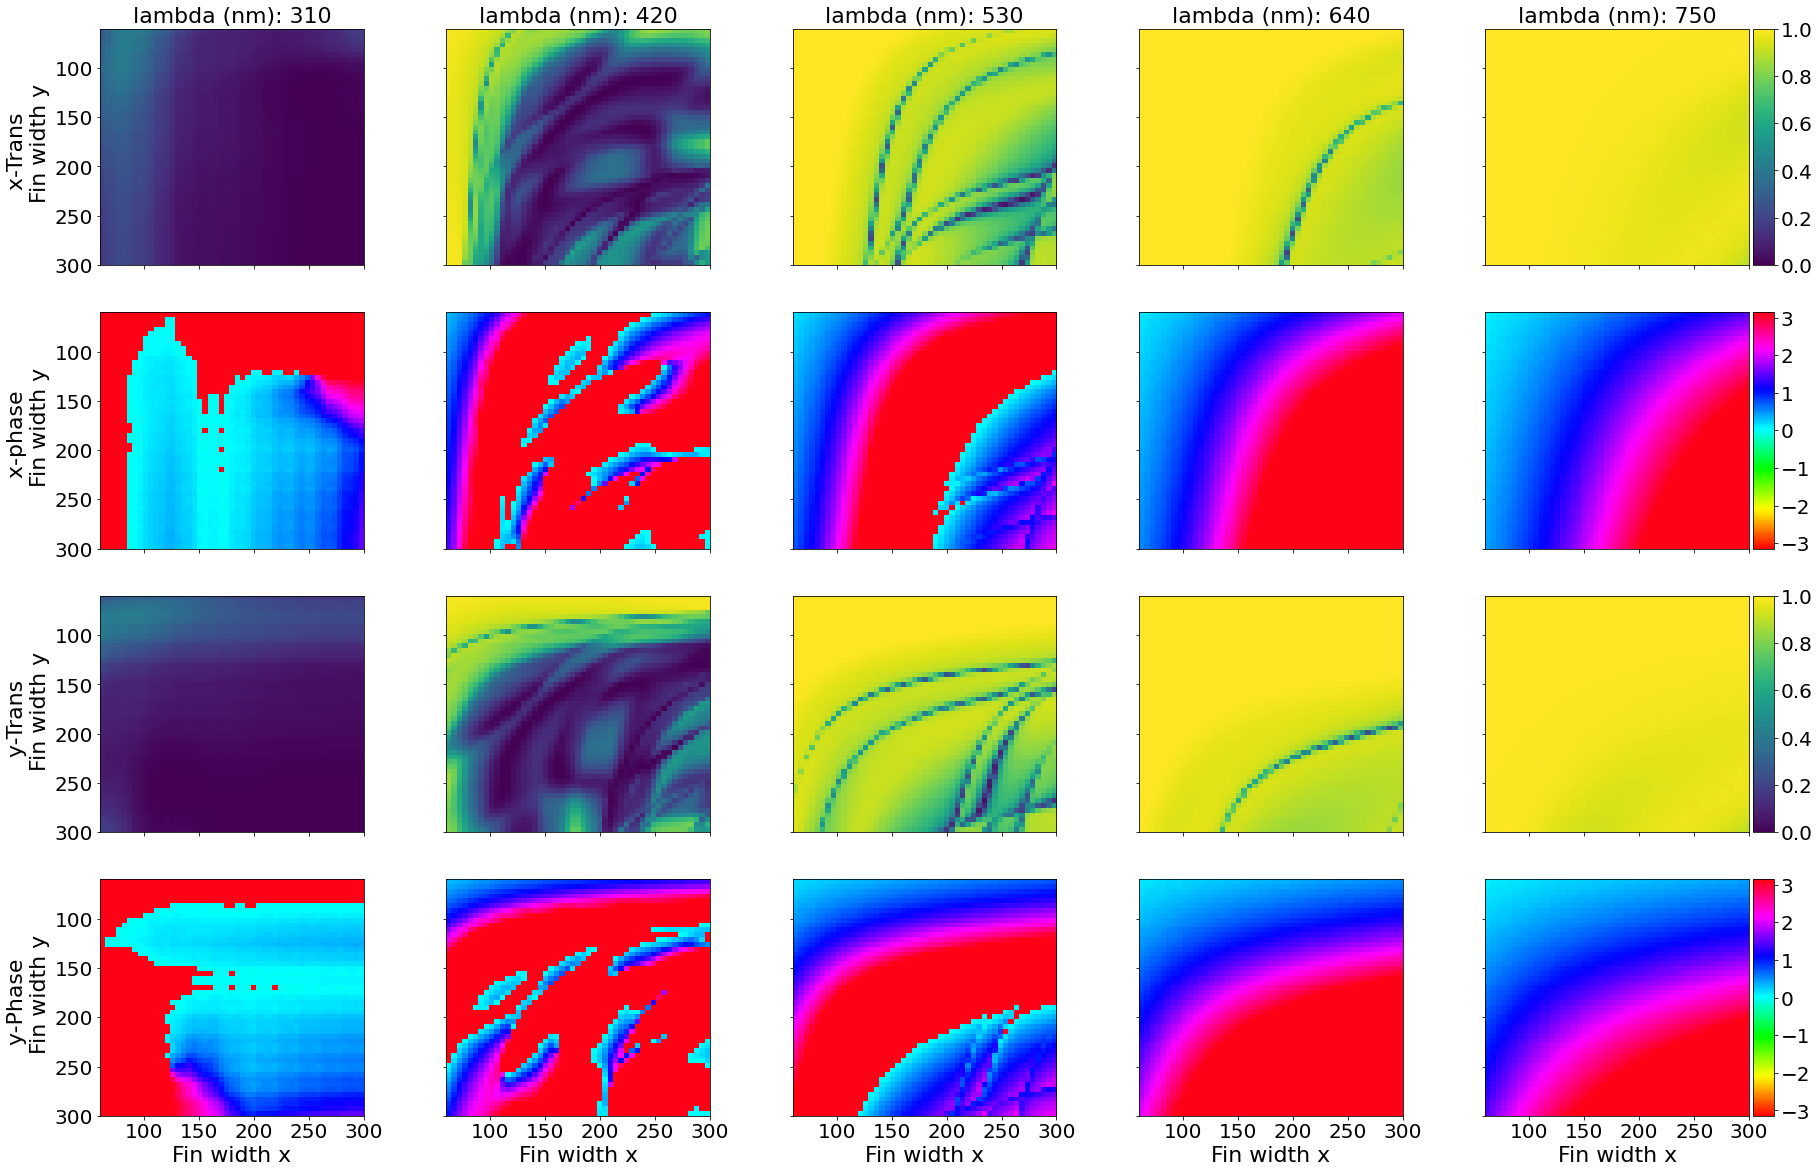

In [ ]:
library = df_library.loadLibrary('Nanofins_U350nm_H600nm')
# Dataset has size [Polarization=2(x,y), lenx, leny, wl_m]
phase = library.phase 
transmission = library.transmission
lenx, leny, wl_m = library.param1, library.param2, library.param3 
print(phase.shape, transmission.shape)

# Call the internal data visualization
library.plotLibrary()

## The nanoellipse class has slightly different phase and transmission but everything is largely the same as the nanofins
## So I will skip the plot here
# library = df_library.loadLibrary('Nanoellipse_U350nm_H600nm')
# phase = library.phase
# transmission = library.transmission
# lenx, leny, wl_m = library.params # .params is a list of meshgrid parameters matching phsae and trans shape
# library.plotLibrary()

(441, 121) (441, 121)


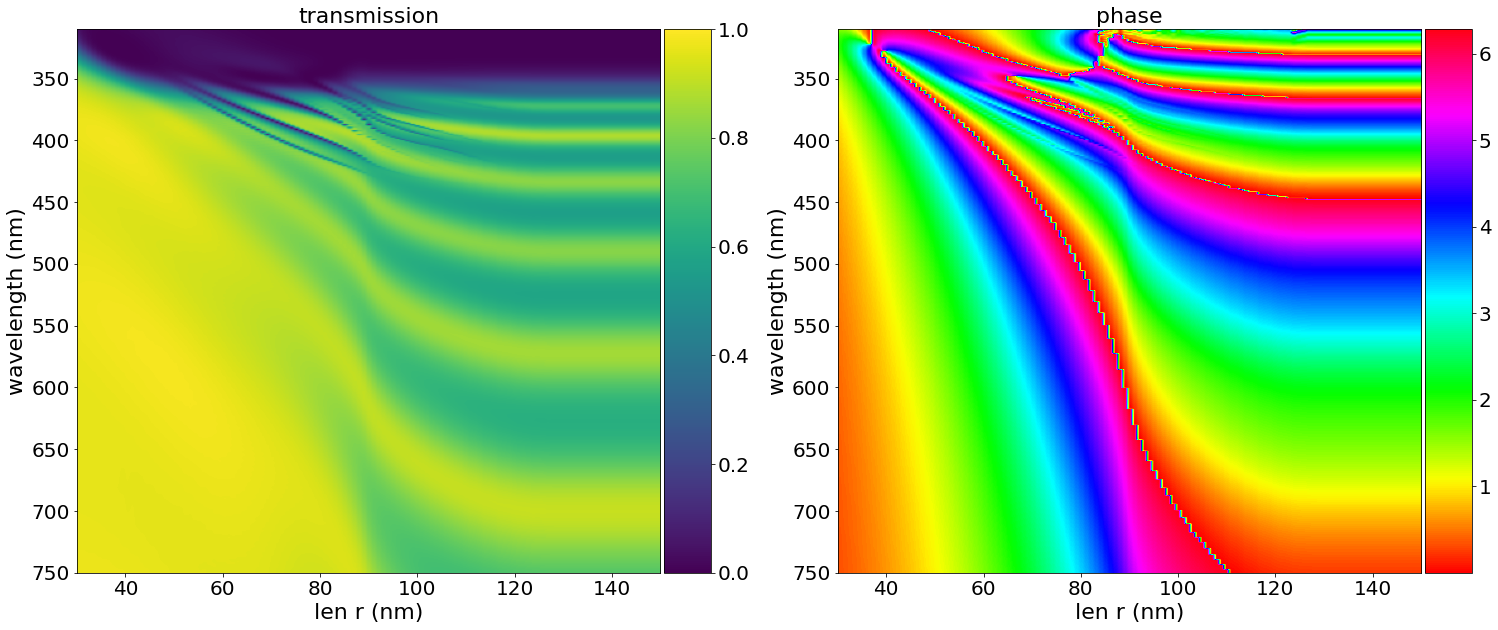

In [ ]:
library = df_library.loadLibrary('Nanocylinders_U180nm_H600nm')
# Phase and transmission data has shape [wl_m, radius]
phase = library.phase
transmission = library.transmission
print(phase.shape, transmission.shape)
radius, wl_m = library.param1, library.param2 

#
library.plotLibrary()

# Loading and Using Pre-trained Neural Models

The neural models are trained to serve as efficient, surrogate models for the above datasets (every model in D$\flat$ has the dataset used to build it included in the repo). 

The key idea is that if we are doing inverse design and we want to optimize a metasurface built from nanofins, for example, we need a differentiable function that maps the cell's shape parameters to the optical response (that being the phase and transmittance at all interested wavelengths). Then we can back-propagate gradients to select the best nanofin width and length at all locations on the metasurface.

All neural models are packaged into a single framework such that they can be loaded by a single function call. 

Neural models inherit the Keras model class and can thus be chained as components in standard Tensorflow sequential deep models. 

If you haven't already, enable GPU runtime in the colab. All neural networks benefit from GPU.

Again we print the available models with the list_models() function. While there are technically more models in the core folder of D$f\lat$, they are hidden to avoid cluttering with unnecessary versions. You could always modify the core source code to see them. 

In [ ]:
import dflat.neural_optical_layer as df_neural
import dflat.plot_utilities as df_plt
import matplotlib.pyplot as plt

In [ ]:
df_neural.list_models()

['ERBF_Nanocylinders_B1024_U180_H600', 'ERBF_Nanofins_B4096_U350_H600', 'MLP_Nanocylinders_Dense256_U180_H600', 'MLP_Nanofins_Dense1024_U350_H600', 'MLP_Nanofins_Dense512_U350_H600', 'MLP_Nanofins_Dense256_U350_H600']


The call below will load the selected model and the backend of the class handles most use-cases.

While the neural models themselves are trained to take inputs of the form $[N,D]$ (and can technically be loaded directly by the load_neuralModel function) where $D$ is the shape-dimensionality, the MLP_layers are designed to take inputs of the shape $[D, pixelsY, pixelsX]$.

This choice is useful because typically you will be using the MLP_layers to evaluate the phase and transmission profiles of an array of metacells like with a metasurface or metalens. You can read more about this in other more advanced tutorials on assembling an end-to-end optimization pipeline. 

A print from the class attributes will show you what D is for the model.

In [ ]:
mlp_model = df_neural.MLP_Layer("MLP_Nanofins_Dense512_U350_H600")
param_dimensionality = mlp_model.param_dimensionality
print("shape dimensionality: ", param_dimensionality)

Checking for model checkpoint at: /content/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanofins_Dense512_U350_H600/

 Model Checkpoint Loaded 

Loaded Model:  MLP_Nanofins_Dense512_U350_H600
shape dimensionality:  2


Again like with the RCWA_Layer class, the model takes normalized shape parameters. In this case, they are normalized according to the bounds of the training data used to generate the model. 

When calling the MLP_Layer, we specify the normalized parameters and a list of wavelengths (in units of meters) that we want to get back the phase and transmission for. If we have particular dimensions.

The class has some built in helpers to make it easier to convert between normalized parameters and physical dimension (units of m) via shape_to_param and param_to_shape.

In [ ]:
import numpy as np
wavelength_list_m = np.array([310, 420, 530, 640, 750])*1e-9
pixelsX = 256
pixelsY = 256

norm_param = np.random.random((param_dimensionality, pixelsY, pixelsX))
shape_vec = mlp_model.param_to_shape(norm_param)
transmittance, phase = mlp_model(norm_param, wavelength_list_m)

The output of this wont look like much since the shapes are randomly selected but we can make alternatively emulate the dataset if we define the input properly. Although we could directly load the neural model directly and pass in a list of $[N,D]$ it is definitely better to use the MLP_Layer since it handles the flow with a single call.

Checking for model checkpoint at: /content/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanocylinders_Dense256_U180_H600/

 Model Checkpoint Loaded 

Loaded Model:  MLP_Nanocylinders_Dense256_U180_H600


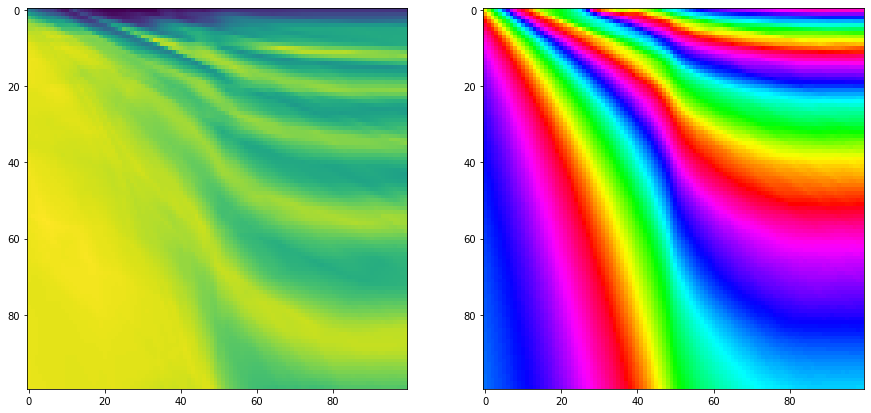

In [ ]:
mlp_model = df_neural.MLP_Layer("MLP_Nanocylinders_Dense256_U180_H600")
param_dimensionality = mlp_model.param_dimensionality

wavelength_m = np.linspace(350e-9, 750e-9, 100)
radius = np.linspace(40e-9, 140e-9, 100)
radius = radius[np.newaxis, :, np.newaxis] # Make it match the input shape of [D, nY, Nx]
norm_param = mlp_model.shape_to_param(radius)
transmittance, phase = mlp_model(norm_param, wavelength_m)

fig = plt.figure(figsize=(15,15))
ax = df_plt.addAxis(fig,1,2)
ax[0].imshow(transmittance[:,0,:,0]**2)
ax[1].imshow(phase[:,0,:,0], cmap="hsv")


Let's do this for the nanofins too. We can use the largest model tested with two hidden layers of 1024 neurons:

Checking for model checkpoint at: /content/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanofins_Dense1024_U350_H600/

 Model Checkpoint Loaded 

Loaded Model:  MLP_Nanofins_Dense1024_U350_H600


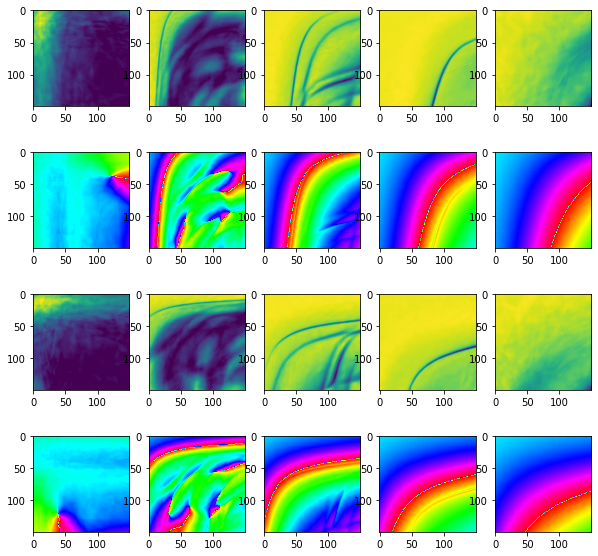

In [ ]:
mlp_model = df_neural.MLP_Layer("MLP_Nanofins_Dense1024_U350_H600")

wavelength_m = np.array([310, 420, 530, 640, 740])*1e-9
lenx = np.linspace(60e-9, 300e-9, 150)
lenx = np.stack(np.meshgrid(lenx, lenx))
param = mlp_model.shape_to_param(lenx)
transmittance, phase = mlp_model(param, wavelength_m)

fig = plt.figure(figsize=(10,10))
ax = df_plt.addAxis(fig,4,5)
for i in range(5):
  ax[i].imshow(transmittance[i,0, :,:]**2)
  ax[i+5].imshow(phase[i,0, :,:], cmap="hsv")
  ax[i+10].imshow(transmittance[i,1, :,:]**2)
  ax[i+15].imshow(phase[i,1, :,:], cmap="hsv")


And also display what the smaller model with two hidden layers of 256 neurons can do:

Checking for model checkpoint at: /content/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanofins_Dense256_U350_H600/

 Model Checkpoint Loaded 

Loaded Model:  MLP_Nanofins_Dense256_U350_H600


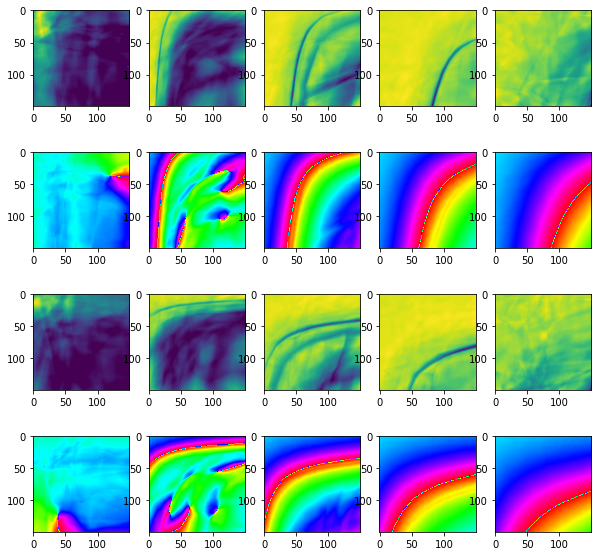

In [ ]:
mlp_model = df_neural.MLP_Layer("MLP_Nanofins_Dense256_U350_H600")

wavelength_m = np.array([310, 420, 530, 640, 740])*1e-9
lenx = np.linspace(60e-9, 300e-9, 150)
lenx = np.stack(np.meshgrid(lenx, lenx))
param = mlp_model.shape_to_param(lenx)
transmittance, phase = mlp_model(param, wavelength_m)

fig = plt.figure(figsize=(10,10))
ax = df_plt.addAxis(fig,4,5)
for i in range(5):
  ax[i].imshow(transmittance[i,0, :,:]**2)
  ax[i+5].imshow(phase[i,0, :,:], cmap="hsv")
  ax[i+10].imshow(transmittance[i,1, :,:]**2)
  ax[i+15].imshow(phase[i,1, :,:], cmap="hsv")


Next time, we will show how to use the MLP_Model in conjunction with the optical propagation layer in order to predict the broadband field produced by a metasurface

Lastly, if more datasets are added (hopefully by the community) more models can be trained with various architectues (again, hopefully done by the community) and they can all be accessed using the same lines of code above